In [555]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/monetlion-assesment/loan.csv
/kaggle/input/monetlion-assesment/payment.csv
/kaggle/input/monetlion-assesment/clarity_underwriting_variables.csv


# Intro  
Loans are a primary revenue stream for many financial institutions. Companies aim to maximize profits by approving more loans while also mitigating risks associated with defaults. **The main goal of the notebook is to enhance the company's ability to identify loans at risk of default by creating a model that complements existing screening systems and reduces potential losses.**



# Table of Content: 

0. Data Loading Overview  
(You may start from here)  
1. Payment DF analysis 
2. Clarity Underwriting variables DF analysis
3. Loan df analysis
4. Data Preprocessing + Feature Engineering
    - Categorical column
    - Datetime Column 
    - Numerical Column
5. Modeling
6. Further Discusssion


# 0. Data Loading Overview
In this section, we'll briefly review the contents of our data files. You can skip this part if you're already familiar with the dataset structure.

Our data is stored in a zipfile and includes three main datasets:

1. clarity_underwriting_variables.csv
2. loan.csv
3. payment.csv

Further analysis and exploration of these datasets will be conducted in the following sections.

In [556]:
%matplotlib inline
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")

In [557]:

loan_df = pd.read_csv('/kaggle/input/monetlion-assesment/loan.csv', parse_dates=['applicationDate', 'originatedDate'])
payment_df = pd.read_csv('/kaggle/input/monetlion-assesment/payment.csv')
underwriting_df = pd.read_csv("/kaggle/input/monetlion-assesment/clarity_underwriting_variables.csv")

In [558]:
df = loan_df.merge(payment_df, on='loanId',how ='left')

In [559]:
loan_df = pd.read_csv('/kaggle/input/monetlion-assesment/loan.csv', parse_dates=['applicationDate', 'originatedDate'])
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577682 entries, 0 to 577681
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   loanId                            577426 non-null  object 
 1   anon_ssn                          577682 non-null  object 
 2   payFrequency                      576409 non-null  object 
 3   apr                               573760 non-null  float64
 4   applicationDate                   577682 non-null  object 
 5   originated                        577682 non-null  bool   
 6   originatedDate                    46044 non-null   object 
 7   nPaidOff                          577658 non-null  float64
 8   approved                          577682 non-null  bool   
 9   isFunded                          577682 non-null  int64  
 10  loanStatus                        577291 non-null  object 
 11  loanAmount                        575432 non-null  f

In [560]:
loan_df

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,0,Withdrawn Application,500.0,978.27,IL,bvMandatory,6,NaN,5669ef78e4b0c9d3936440e6,1
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,Checked,569eb3a3e4b096699f685d64,1
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,0,Withdrawn Application,400.0,1199.45,MO,bvMandatory,3,NaN,579eab11e4b0d0502870ef2f,1
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,0,Withdrawn Application,500.0,1074.05,IL,bvMandatory,3,NaN,555b1e95e4b0f6f11b267c18,1
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,0,Rejected,350.0,814.37,NV,bvMandatory,3,NaN,5754a91be4b0c6a2bf424772,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577677,LL-I-12122269,801262d04720d32040612759857f4147,B,590.0,2016-11-08T17:32:33.554000,False,NaN,0.0,False,0,Withdrawn Application,400.0,1292.41,NV,bvMandatory,3,NaN,58220cdde4b051c58d919c1f,1
577678,LL-I-16183462,e37750de9d99a67e0fa96a51e86fdf5b,S,490.0,2017-01-24T22:20:59.818000,False,NaN,0.0,False,0,Withdrawn Application,1000.0,2592.39,MO,lead,25,NaN,5887d349e4b08f249ac45e2f,1
577679,LL-I-06962710,d7e55e85266208ac4c353f42ebcde5ca,B,590.0,2016-02-02T03:05:47.797000,False,NaN,0.0,False,0,Withdrawn Application,300.0,844.75,IN,bvMandatory,6,NaN,550b1f59e4b0d4592e28c84e,1
577680,LL-I-01253468,c3b35307cb36116bf59574f9138d3dad,B,550.0,2015-05-21T20:19:49.639000,False,NaN,0.0,False,0,Withdrawn Application,300.0,770.80,OH,organic,6,NaN,NaN,0


In [561]:
loan_df.loanStatus.value_counts()

loanStatus
Withdrawn Application          450984
Rejected                        85070
Paid Off Loan                   11427
External Collection             11334
New Loan                         8112
Internal Collection              5567
Returned Item                    1182
CSR Voided New Loan              1026
Settlement Paid Off               708
Credit Return Void                704
Customer Voided New Loan          504
Settled Bankruptcy                326
Pending Paid Off                  169
Charged Off Paid Off              160
Pending Application Fee             5
Pending Rescind                     4
Pending Application                 4
Voided New Loan                     2
Charged Off                         1
Customver Voided New Loan           1
Settlement Pending Paid Off         1
Name: count, dtype: int64

In [562]:
loan_df.duplicated().sum()

0

In [563]:
loan_df.loanId.nunique()

577426

In [564]:
payment_df

,loanId,installmentIndex,isCollection,paymentDate,principal,fees,paymentAmount,paymentStatus,paymentReturnCode
0,LL-I-00000021,1,False,2014-12-19T05:00:00,22.33,147.28,169.61,Checked,NaN
1,LL-I-00000021,2,False,2015-01-02T05:00:00,26.44,143.17,169.61,Checked,NaN
2,LL-I-00000021,3,False,2015-01-16T05:00:00,31.30,138.31,169.61,Checked,NaN
3,LL-I-00000021,4,False,2015-01-30T05:00:00,37.07,132.54,169.61,Checked,NaN
4,LL-I-00000021,5,False,2015-02-13T05:00:00,43.89,125.72,169.61,Checked,NaN
...,...,...,...,...,...,...,...,...,...
689359,LL-I-18629478,8,False,2017-07-14T04:00:00,45.62,17.67,63.29,NaN,NaN
689360,LL-I-18629478,9,False,2017-07-31T04:00:00,45.67,17.62,63.29,NaN,NaN
689361,LL-I-18629478,10,False,2017-08-15T04:00:00,51.12,12.17,63.29,NaN,NaN
689362,LL-I-18629478,11,False,2017-08-31T04:00:00,54.35,8.94,63.29,NaN,NaN


# Payment DF analysis

We start of by analyzing the Payment DataFrame. Our observation reveals that 97.3% of this dataset is associated with funded loans, suggesting that **most of the payment info comes after loan approval. Since our model's goal is to act as a secondary safety measure prior to loan approval, this dataset will be excluded to avoid information leakage.**

In [565]:
payment_df['loanId'].nunique()

39952

In [566]:
merged_df = payment_df.merge(loan_df, on='loanId', how='inner')
filtered_df = merged_df[merged_df['isFunded'] == 1]
count_originated = filtered_df['loanId'].nunique()
count_originated

38878

In [567]:
(count_originated/payment_df['loanId'].nunique() )*100

97.31177412895474

# Clarity Underwriting variables DF analysis

Moving on to the Clarity Underwriting Variables DataFrame. This dataset encompasses variables retrieved from clarity, aiding in the underwriting process of loans. In simpler terms, it involves assessing the risk associated with a loan by evaluating various factors (columns) to determine the probability of the borrower repaying the loan. It's likely that the company favors approving loans with underwriting variables as they offer a more holistic view of a borrower's creditworthiness, leading to well-informed lending decisions.

Upon reviewing the dataset, it appears that the "clearFraudScore" serves as a summarizing score derived from all other columns in the dataset. We assume that all other columns are well represented by this particular column. Consequently, we may consider dropping all other columns to streamline our dataset and reduce dimensionality.

In [568]:
df = loan_df.merge(underwriting_df, left_on='clarityFraudId', right_on='underwritingid',how ='left')
df

,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtypedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonetype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncode,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssndobmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.overallmatchreasoncode,clearfraudscore,underwritingid
0,LL-I-07399092,beff4989be82aab4a5b47679216942fd,B,360.0,2016-02-23T17:29:01.940000,False,NaN,0.0,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,True,2016-01-20T15:49:18.846000,0.0,True,1,...,NaN,partial,NaN,D04,NaN,NaN,invalid,5.0,879.0,569eb3a3e4b096699f685d64
2,LL-I-10707532,3c174ae9e2505a5f9ddbff9843281845,B,590.0,2016-08-01T13:51:14.709000,False,NaN,0.0,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LL-I-02272596,9be6f443bb97db7e95fa0c281d34da91,B,360.0,2015-08-06T23:58:08.880000,False,NaN,0.0,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LL-I-09542882,63b5494f60b5c19c827c7b068443752c,B,590.0,2016-06-05T22:31:34.304000,False,NaN,0.0,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577677,LL-I-12122269,801262d04720d32040612759857f4147,B,590.0,2016-11-08T17:32:33.554000,False,NaN,0.0,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577678,LL-I-16183462,e37750de9d99a67e0fa96a51e86fdf5b,S,490.0,2017-01-24T22:20:59.818000,False,NaN,0.0,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577679,LL-I-06962710,d7e55e85266208ac4c353f42ebcde5ca,B,590.0,2016-02-02T03:05:47.797000,False,NaN,0.0,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577680,LL-I-01253468,c3b35307cb36116bf59574f9138d3dad,B,550.0,2015-05-21T20:19:49.639000,False,NaN,0.0,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [569]:
df.groupby('leadType')['clearfraudscore'].count().sort_values(ascending=False)

leadType
bvMandatory      15740
lead             12059
organic           6806
prescreen         1399
rc_returning       147
california          58
instant-offer       12
lionpay              2
express              1
repeat               1
Name: clearfraudscore, dtype: int64

- As we can see from the result above, most of the applicant with underwriting variables is the lead that company bought from third parties. 

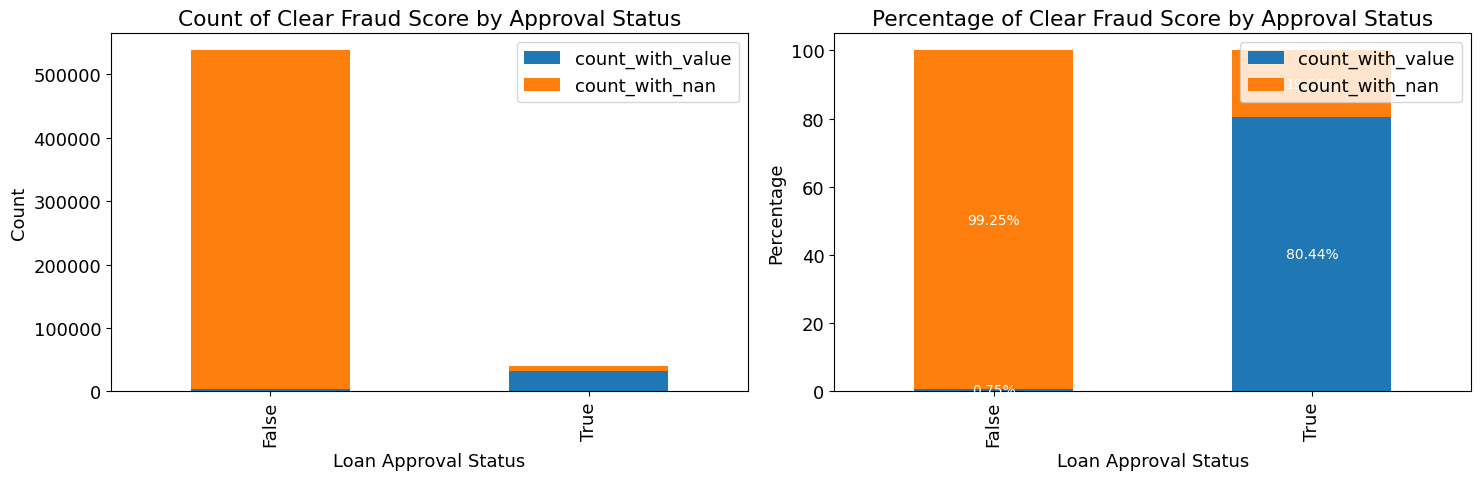

In [570]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Group by 'approved' and calculate counts
grouped_counts = df.groupby('approved')['clearfraudscore'].agg(count_with_value=lambda x: x.count(), count_with_nan=lambda x: x.isnull().sum())

# Calculate percentages
total_counts = grouped_counts.sum(axis=1)
percentage_counts = grouped_counts.div(total_counts, axis=0) * 100

# Plotting on first subplot
ax2 = grouped_counts.plot(kind='bar', stacked=True, ax=axes[0])

# Set plot labels and title for the first subplot
ax2.set_xlabel('Loan Approval Status')
ax2.set_ylabel('Count')
ax2.set_title('Count of Clear Fraud Score by Approval Status')

# Plotting on second subplot
ax1 = percentage_counts.plot(kind='bar', stacked=True, ax=axes[1])

# Annotate bars with percentages for the second subplot
for p in ax1.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax1.annotate(f'{height:.2f}%', (x + width/2, y + height/2), ha='center', va='center', fontsize=10, color='white')

# Set plot labels and title for the second subplot
ax1.set_xlabel('Loan Approval Status')
ax1.set_ylabel('Percentage')
ax1.set_title('Percentage of Clear Fraud Score by Approval Status')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Based on the graph above, around **80.44%** of approved loans are associated with a Clear Fraud Score. This suggests that MoneyLion is likely to employ this score as a primary screening tool to identify and filter out potentially risky loans.

# Loan df analysis

Moving on to the main data for this task. As per our objective, our model aim to serve as a complementary to the current screening system. We will narrow down our focus to loans that **have been funded**. From here, we will further dive in and hopefully to provide a more indepth analysis.

Refering to the data dictionary, the "Return Item" under loanStatus column seems to be a good fit for our target variable as it indicate a missed payment due to insufficient funds. But we are also curious with other loanStatus like "External/Internal collection". Does it really indicates timely repayment? Due to the absence of additional information, we've decided to stick with "Return Item" as our primary target variable for now. Further insights could be gained with more detailed data on these other categories.

In [571]:
selected_cols = ['clearfraudscore', 'underwritingid']
new_underwriting_df = underwriting_df[selected_cols]
df = loan_df.merge(new_underwriting_df, left_on='clarityFraudId', right_on='underwritingid',how ='left')

In [572]:
df = df[df['isFunded'] == 1]
useless_col = ['underwritingid' ,'clarityFraudId','hasCF','fpStatus','originated','approved', 'isFunded']
df = df.drop(useless_col, axis = 1)

df

,loanId,anon_ssn,payFrequency,apr,applicationDate,originatedDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,clearfraudscore
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,2016-01-20T15:49:18.846000,0.0,Paid Off Loan,3000.0,6395.19,CA,prescreen,0,879.0
15,LL-I-12263369,accf40708233e8b7d05fcb89d5a9c081,B,475.0,2016-11-28T19:54:22.982000,2016-11-29T20:30:40.640000,2.0,New Loan,350.0,893.88,MO,organic,0,NaN
33,LL-I-17826953,7529d29c9d943cc55bc71a85d9c6b7a3,W,645.0,2017-03-01T15:55:41.823000,2017-03-01T16:15:13.016000,0.0,New Loan,400.0,1364.87,NJ,lead,40,658.0
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31T17:48:17.381000,2017-01-31T18:00:14.520000,2.0,Paid Off Loan,1250.0,3313.78,MO,organic,0,835.0
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27T09:08:05.442000,2016-08-29T15:05:04.014000,0.0,Paid Off Loan,800.0,2432.08,CA,bvMandatory,10,624.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577564,LL-I-12367915,55392b05f72f8c3e32e5157612406ba8,B,565.0,2016-12-01T16:57:49.231000,2016-12-01T17:28:21.872000,3.0,Paid Off Loan,600.0,1670.18,CA,rc_returning,0,NaN
577590,LL-I-15280684,73690518af906288434b2a0cfd972fe0,M,645.0,2017-01-14T19:43:08.685000,2017-01-14T20:00:10.426000,0.0,Paid Off Loan,375.0,1042.40,AL,lead,25,700.0
577617,LL-I-09897110,0538f828b4a0b44502ead5a8033ee779,B,449.0,2016-06-22T01:10:50.110000,2016-06-22T21:46:54.359000,0.0,Paid Off Loan,400.0,664.12,WI,lead,40,806.0
577653,LL-I-14178923,d9a63e9e15b862fcaaf3653c52e1f16c,B,625.0,2016-12-30T15:49:39.785000,2016-12-30T16:00:12.500000,0.0,New Loan,600.0,1868.88,IN,lead,25,769.0


In [573]:
df.loanStatus.value_counts()

loanStatus
Paid Off Loan                  11427
External Collection            11334
New Loan                        8112
Internal Collection             5564
Returned Item                   1182
Settlement Paid Off              708
Settled Bankruptcy               325
Pending Paid Off                 169
Charged Off Paid Off             159
Charged Off                        1
Settlement Pending Paid Off        1
Name: count, dtype: int64

We noticed that our dataset includes 'New Loan' entries, which wouldn't be fair for us to categorize as either 'default' or 'non-default.' Therefore, we will filter out these new loans from our analysis.

In [574]:
df = df[df['loanStatus'] != 'New Loan']
df['loanStatus'] = df['loanStatus'].apply(lambda x: 1 if x == 'Returned Item' else 0)
df

,loanId,anon_ssn,payFrequency,apr,applicationDate,originatedDate,nPaidOff,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,clearfraudscore
1,LL-I-06644937,464f5d9ae4fa09ece4048d949191865c,B,199.0,2016-01-19T22:07:36.778000,2016-01-20T15:49:18.846000,0.0,0,3000.0,6395.19,CA,prescreen,0,879.0
47,LL-I-16519347,bc9fa73468acf18cb968a3a6a3c4697c,S,490.0,2017-01-31T17:48:17.381000,2017-01-31T18:00:14.520000,2.0,0,1250.0,3313.78,MO,organic,0,835.0
54,LL-I-11506719,10cefd11d41612b032fd9cd2debe32dc,B,590.0,2016-08-27T09:08:05.442000,2016-08-29T15:05:04.014000,0.0,0,800.0,2432.08,CA,bvMandatory,10,624.0
64,LL-I-09279047,1d249e27292d25e4d3b4bc142a2a4aea,W,404.1,2016-05-25T03:05:18.849000,2016-05-25T15:11:36.260000,3.0,0,300.0,422.64,WI,organic,0,770.0
83,LL-I-18297678,bc500677542783c43842d54e34830f08,B,315.0,2017-03-12T18:24:46.356000,2017-03-12T19:00:23.818000,2.0,0,1500.0,2875.27,IL,organic,0,932.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577521,LL-I-17508871,f0b666fdd1b46c58297b3828b61047ad,M,180.2,2017-02-21T20:29:57.538000,2017-02-21T20:45:06.563000,0.0,1,500.0,794.60,CO,lead,25,695.0
577564,LL-I-12367915,55392b05f72f8c3e32e5157612406ba8,B,565.0,2016-12-01T16:57:49.231000,2016-12-01T17:28:21.872000,3.0,0,600.0,1670.18,CA,rc_returning,0,NaN
577590,LL-I-15280684,73690518af906288434b2a0cfd972fe0,M,645.0,2017-01-14T19:43:08.685000,2017-01-14T20:00:10.426000,0.0,0,375.0,1042.40,AL,lead,25,700.0
577617,LL-I-09897110,0538f828b4a0b44502ead5a8033ee779,B,449.0,2016-06-22T01:10:50.110000,2016-06-22T21:46:54.359000,0.0,0,400.0,664.12,WI,lead,40,806.0


In [575]:
# df['applicationDate'] = pd.to_datetime(df['applicationDate'], format="%Y-%m-%dT%H:%M:%S")

date_col = ['applicationDate', 'originatedDate']
for i in date_col:
    df[i] = pd.to_datetime(df[i], format = 'ISO8601')

After some preliminary data cleaning, we are now good to go with a more indepth analysis

Reason why to remove columns above:  
- 'underwritingid'/'clarityFraudId': These columns are redundant after merging the underwriting dataframe with the loan dataframe.
- 'hasCF': Upon exploration, we deduced that 'hasCF' likely represents the presence of ClearFraud or ClarityFraud, which is already indicated by the clearfraudscore being null or not null.
- 'fpStatus': Our model operates before the loan is funded, so we don't have access to the first payment status.
- 'originated'/'approved': These columns are unnecessary since we are focusing on funded loans, which are by definition approved and originated.
- 'isFunded': This column is redundant as the entire dataset consists only of loans that have been funded.



# Data Preprocessing + Feature Engineering

In this section, we will categorize the dataset into three types: Categorical, Datetime, and Numerical data. We will process each data type separately, create new features where applicable, and provide business insights to the company.

In [576]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30870 entries, 1 to 577662
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            30870 non-null  object        
 1   anon_ssn                          30870 non-null  object        
 2   payFrequency                      30870 non-null  object        
 3   apr                               30870 non-null  float64       
 4   applicationDate                   30870 non-null  datetime64[ns]
 5   originatedDate                    30870 non-null  datetime64[ns]
 6   nPaidOff                          30849 non-null  float64       
 7   loanStatus                        30870 non-null  int64         
 8   loanAmount                        30870 non-null  float64       
 9   originallyScheduledPaymentAmount  30870 non-null  float64       
 10  state                             30870 non-null  

In [577]:
def check_nan(df):
    return (df.isnull().sum().sort_values(ascending=False) / len(df.index)) * 100
    
check_nan(df)

clearfraudscore                     17.197927
nPaidOff                             0.068027
loanId                               0.000000
anon_ssn                             0.000000
payFrequency                         0.000000
apr                                  0.000000
applicationDate                      0.000000
originatedDate                       0.000000
loanStatus                           0.000000
loanAmount                           0.000000
originallyScheduledPaymentAmount     0.000000
state                                0.000000
leadType                             0.000000
leadCost                             0.000000
dtype: float64

In [578]:
df.duplicated().sum()

0

In [579]:
def remove_outliers_iqr(df, columns):
    df_cleaned = df.copy()
    for col in columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    return df_cleaned

# List of columns to check for outliers
columns_to_check = ['apr', 'loanAmount', 'originallyScheduledPaymentAmount']

# Call the function to remove outliers
df = remove_outliers_iqr(df, columns_to_check)

print(df_cleaned.shape)


(27578, 16)


In [580]:
df.columns

Index(['loanId', 'anon_ssn', 'payFrequency', 'apr', 'applicationDate',
       'originatedDate', 'nPaidOff', 'loanStatus', 'loanAmount',
       'originallyScheduledPaymentAmount', 'state', 'leadType', 'leadCost',
       'clearfraudscore'],
      dtype='object')

In [581]:
df[(df['leadCost']>=25) &(df['leadCost']<=50)]['leadType'].value_counts()

leadType
lead    3772
Name: count, dtype: int64

## Categorical Column

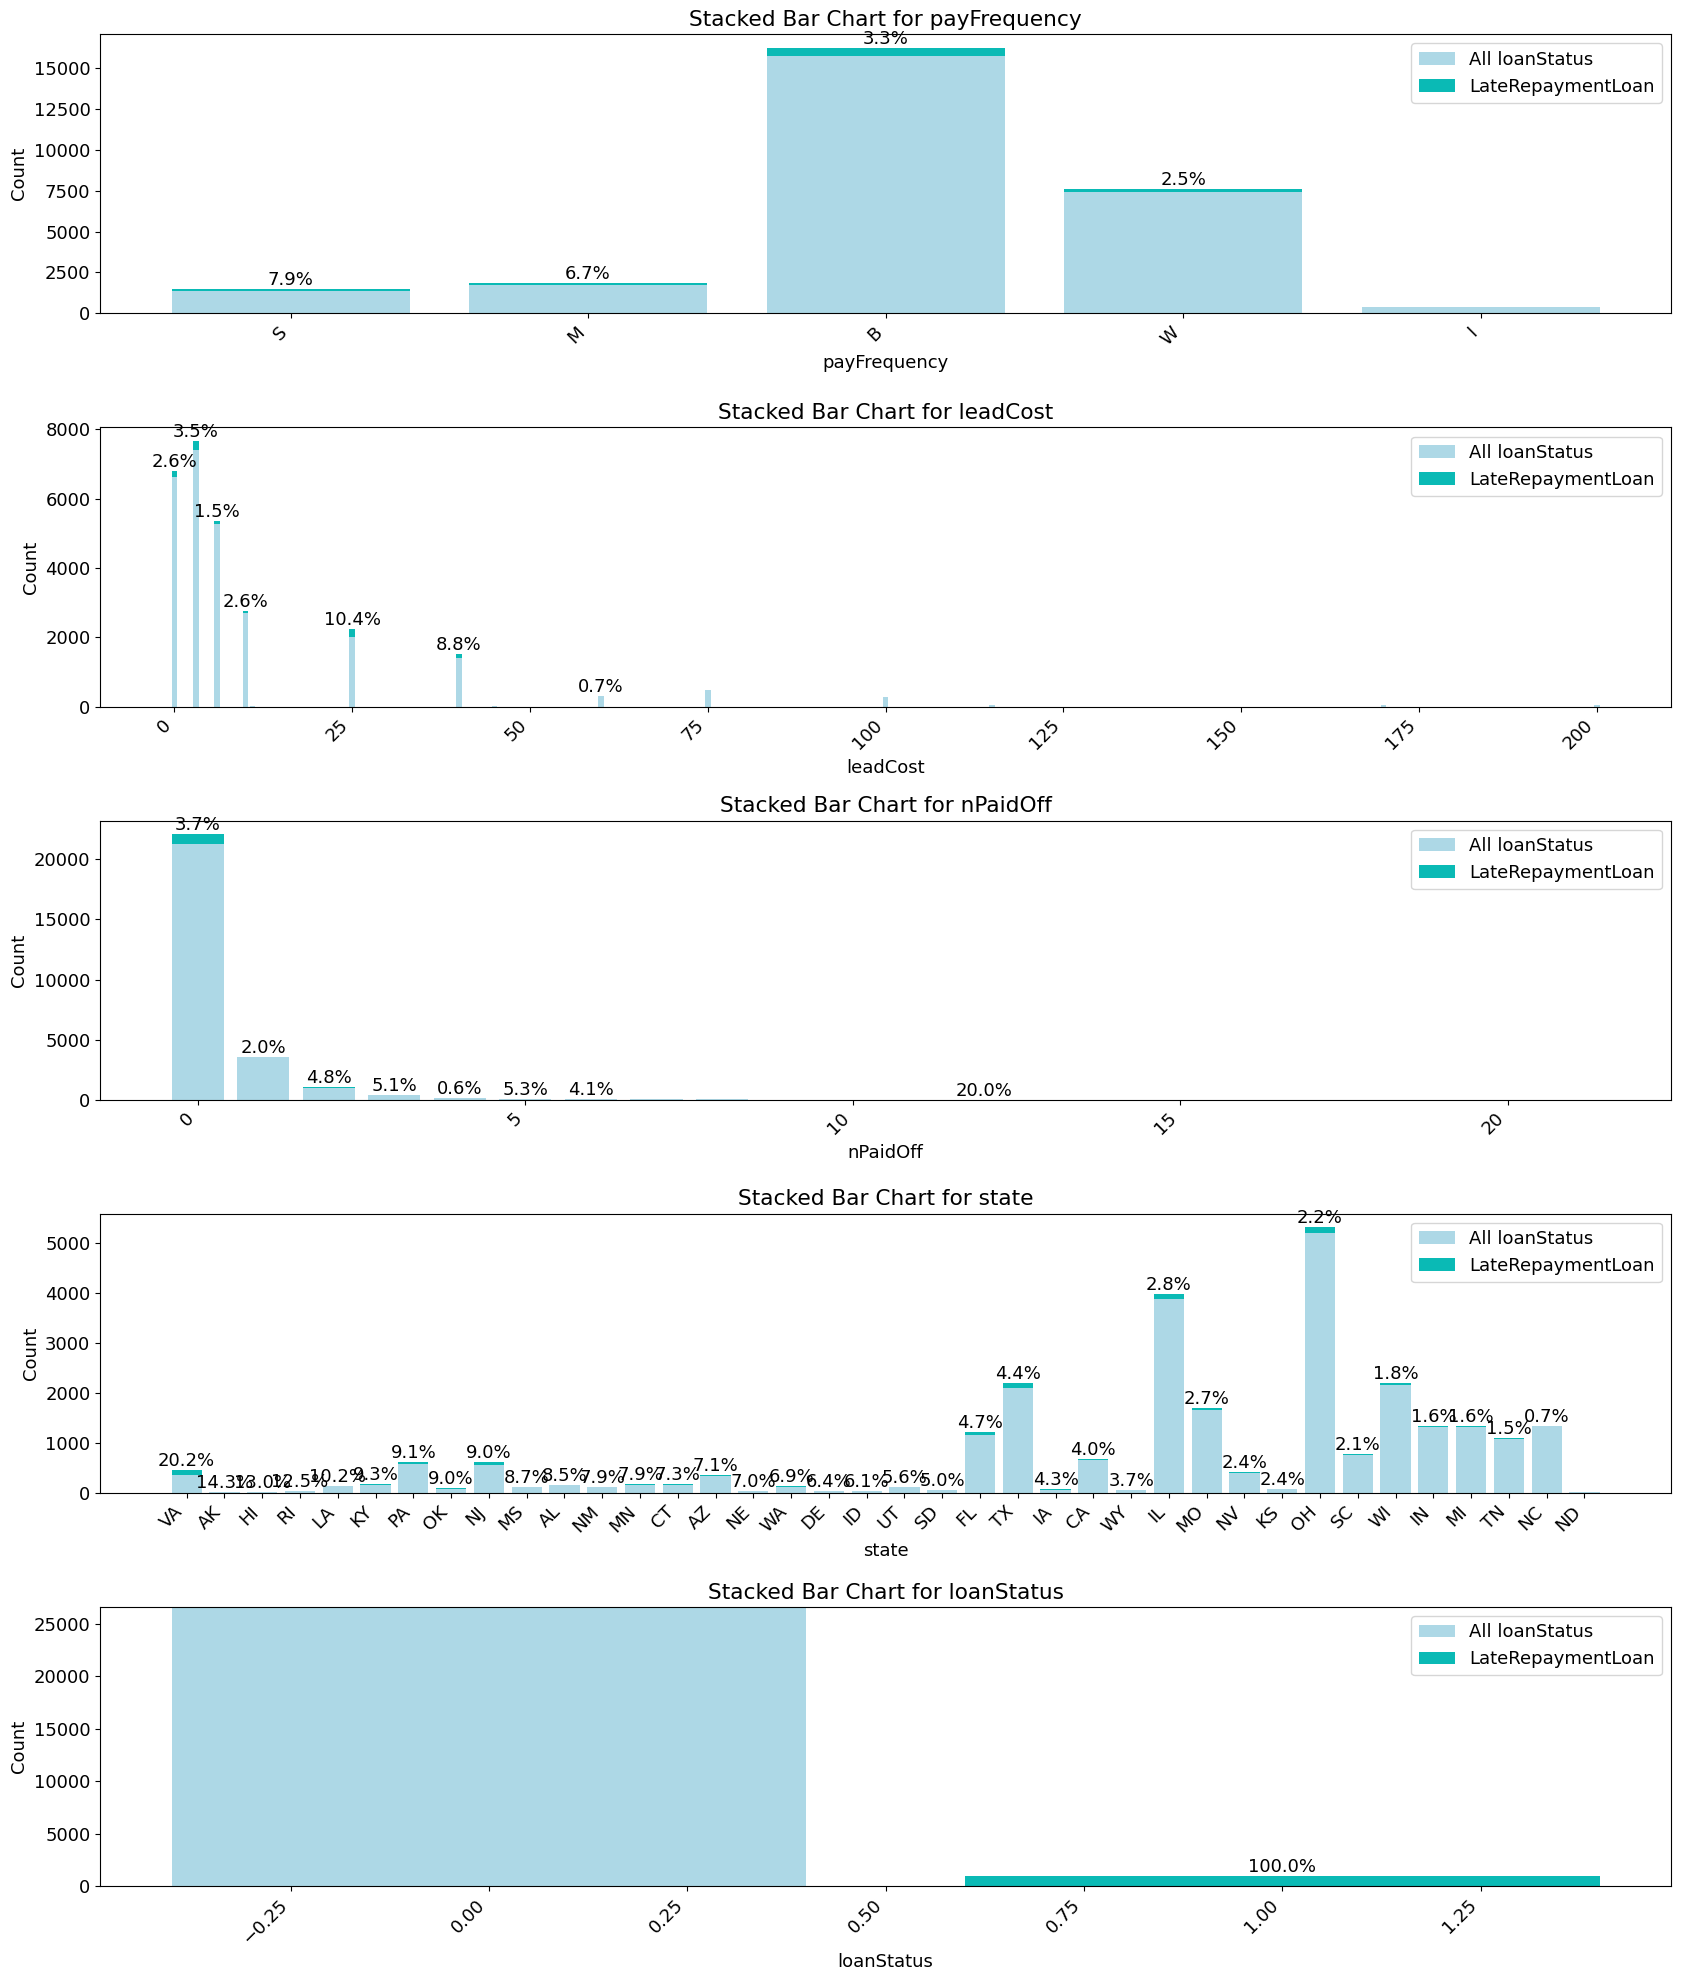

In [582]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(17, 20))

# List of columns to plot
columns = ['payFrequency', 'leadCost', 'nPaidOff', 'state', 'loanStatus']

# Define custom colors for bars
light_blue = '#ADD8E6'
tiffany_green = '#0abab5'

# Loop through each column
for i, col in enumerate(columns, start=1):
    # Calculate value counts for the entire dataset
    all_counts = df[col].value_counts().reset_index()
    all_counts.columns = [col, 'all_count']
    
    # Calculate value counts for loanStatus == 1
    filtered_counts = df[df['loanStatus'] == 1][col].value_counts().reset_index()
    filtered_counts.columns = [col, 'filtered_count']
    
    # Merge counts into a single DataFrame
    merged_counts = pd.merge(all_counts, filtered_counts, on=col, how='left').fillna(0)
    
    # Calculate the percentage
    merged_counts['percentage'] = (merged_counts['filtered_count'] / merged_counts['all_count']) * 100
    
    # Sort merged_counts by percentage in descending order
    merged_counts = merged_counts.sort_values(by='percentage', ascending=False)
    
    # Plot stacked bar chart
    plt.subplot(len(columns), 1, i)
    bar1 = plt.bar(merged_counts[col], merged_counts['all_count'], label='All loanStatus', color=light_blue)
    bar2 = plt.bar(merged_counts[col], merged_counts['filtered_count'], bottom=merged_counts['all_count'] - merged_counts['filtered_count'], label='LateRepaymentLoan', color=tiffany_green)
    
    # Add percentage text within the bar (optional)
    for j in range(len(merged_counts)):
        if merged_counts['filtered_count'][j] > 0:
            plt.text(
                merged_counts[col][j], 
                merged_counts['all_count'][j], 
                f"{merged_counts['percentage'][j]:.1f}%", 
                ha='center', 
                va='bottom', 
                color='black'
            )
    
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Stacked Bar Chart for {col}')
    plt.xticks(rotation=45, ha='right')
    plt.legend()

plt.tight_layout()
plt.show()



Here are the findings from our data exploration:

- Semi-monthly and monthly repayment schedules have nearly twice the likelihood of loan default compared to biweekly and weekly repayments. This is likely because weekly payments involve smaller amounts each time. As a business strategy, the company should consider promoting more frequent repayment schedules to reduce the risk of loan defaults.
- We observed that lead costs between 25 and 50 are associated with the highest default risk. Upon further investigation, we found that these leads are categorized as "lead" in the lead type column. MoneyLion is advised to reduce the approval rate for this category to mitigate risk.
- The history of paid-off loans does not significantly impact the associated default risk.
- Many states have a loan default rate of 10% or higher. It is recommended that the company reduce loan approvals in these states, with particular attention to Virginia (VA), which has a 20% default rate.
- Our dataset shows a significant class imbalance, which we will address in the modeling section.

In [583]:
cat_col = ['payFrequency','state','leadType', 'state']
label_encoder = LabelEncoder()
for i in cat_col:
    df[i] = label_encoder.fit_transform(df[i])

In [584]:
df['nPaidOff'] = df['nPaidOff'].fillna(0)

In [585]:
df['nPaidOff'] = df['nPaidOff'].astype(int)

We've also noticed that the 'nPaidOff' column has a float data type. Converting it to an integer should be a more appropriate approach. It's important to note that we haven't split the dataset into training and testing sets yet. Imputing values such as mean, median, or mode at this stage could lead to data leakage. However, for the time being, we will simply fill missing values with 0, which is an acceptable interim solution.

## Datetime Column

In this section, we've introduced two new features:

- 'application_month': This feature captures the month in which the loan application was submitted.
- 'application_2_originated_time': This feature represents the time difference between loan origination and application submission.


In [586]:
df['applicationDate'].min(), df['applicationDate'].max()

(Timestamp('2014-12-03 00:31:22.306000'),
 Timestamp('2017-03-18 23:34:27.369000'))

This dataset contains incomplete data for the years 2014 and 2017.

Text(0.5, 1.0, 'Month vs Default risk')

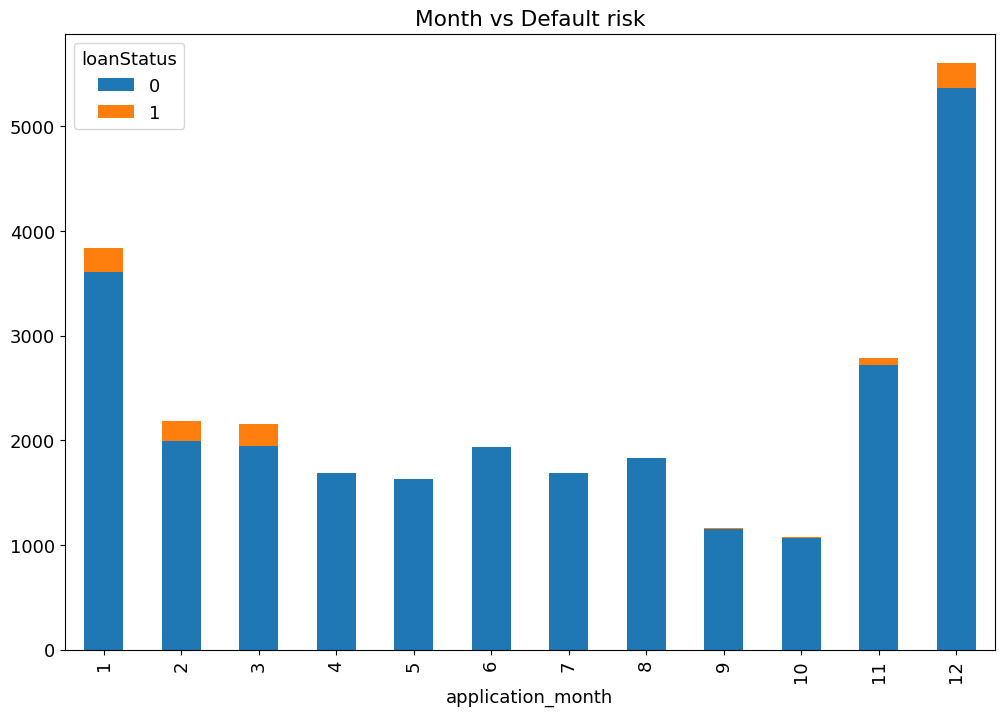

In [587]:
df['application_month'] = df['applicationDate'].dt.month

grouped_df = df.groupby('application_month')['loanStatus'].value_counts()

unstacked_df = grouped_df.unstack()

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
unstacked_df.plot(kind='bar', stacked=True, ax=ax)
plt.title("Month vs Default risk")


- loanStatus 0 = no late repayment, loanStatus 1 = late repayment  

Finding:
- November to February : higher loan demand + higher incidence of late repayments
- April to Octover : no instances of late repayment 

Based on the finding above, we may infer that people tend to borrow a loan when it comees to holiday season(Christmas, Newyear) where they are more likely to make impulse purchases which they couldnt afford, thats why we see a late of repayment in the following few months. But those who ask for loan during the middle of the year exhibit a commendable record of timely repayment. **This may be a good business insights for the company as we can reduce loan during holiday season while incrasing loan during normal season to maximize profit while minizing risk of default loan.**

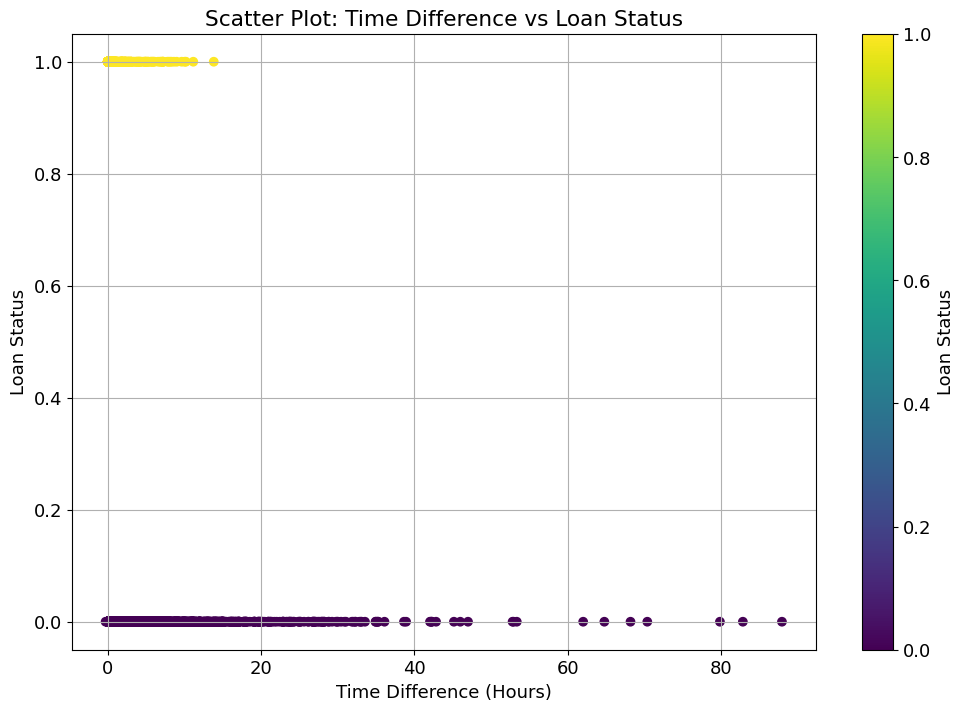

In [588]:
df['application_2_originated_time'] = (df['originatedDate'] - df['applicationDate']).dt.total_seconds() / (60*60*24)

# Convert the timedelta to float by extracting the total minutes
df['application_2_originated_time'] = df['application_2_originated_time'].astype('float')

df1 = df[df['application_2_originated_time']<=100]

# Assuming df['application_2_originated_time'] contains time differences in days or another appropriate format
# Scatter plot with loan status color-coded
plt.figure(figsize=(12, 8))
plt.scatter(df1['application_2_originated_time'], df1['loanStatus'], c=df1['loanStatus'], cmap='viridis')
plt.xlabel('Time Difference (Hours)')
plt.ylabel('Loan Status')
plt.title('Scatter Plot: Time Difference vs Loan Status')
plt.colorbar(label='Loan Status')
plt.grid(True)

# custom_ticks = [5, 10, 15, 20, 25, 30]
# plt.xticks(custom_ticks)

# tick_interval = 100  # Set the interval between ticks
# ticks = np.arange(0, 2000, tick_interval)  # Generate ticks with the specified interval
# plt.xticks(ticks)
plt.show()

Originated: when the lender officially approves application and agrees to give the money  

Finding:
- Most loan application is originated within 40 hours
- **All** late repayment loan is originated within 17 hours

**We've noticed a trend where loans with longer originated times are less likely to default**. Assuming we have a SOP before originated, we wonder why some of the loan have a longer originated time, does it include any extra information collection process? Can we apply that to applicantions with a shorter originated time? However, due to the lack of detailed information, we are unable to delve deeper into this matter at present.


## Numerical Column

Common techniques like scaling/handling missing value/adjusting distribution is **not neccessary** in this part, as we will be using LGBM as our model. (LGBM doesnt assume linearity + can handle missing value by itself + robust to skewness). Thats whyy I like LGBM :)


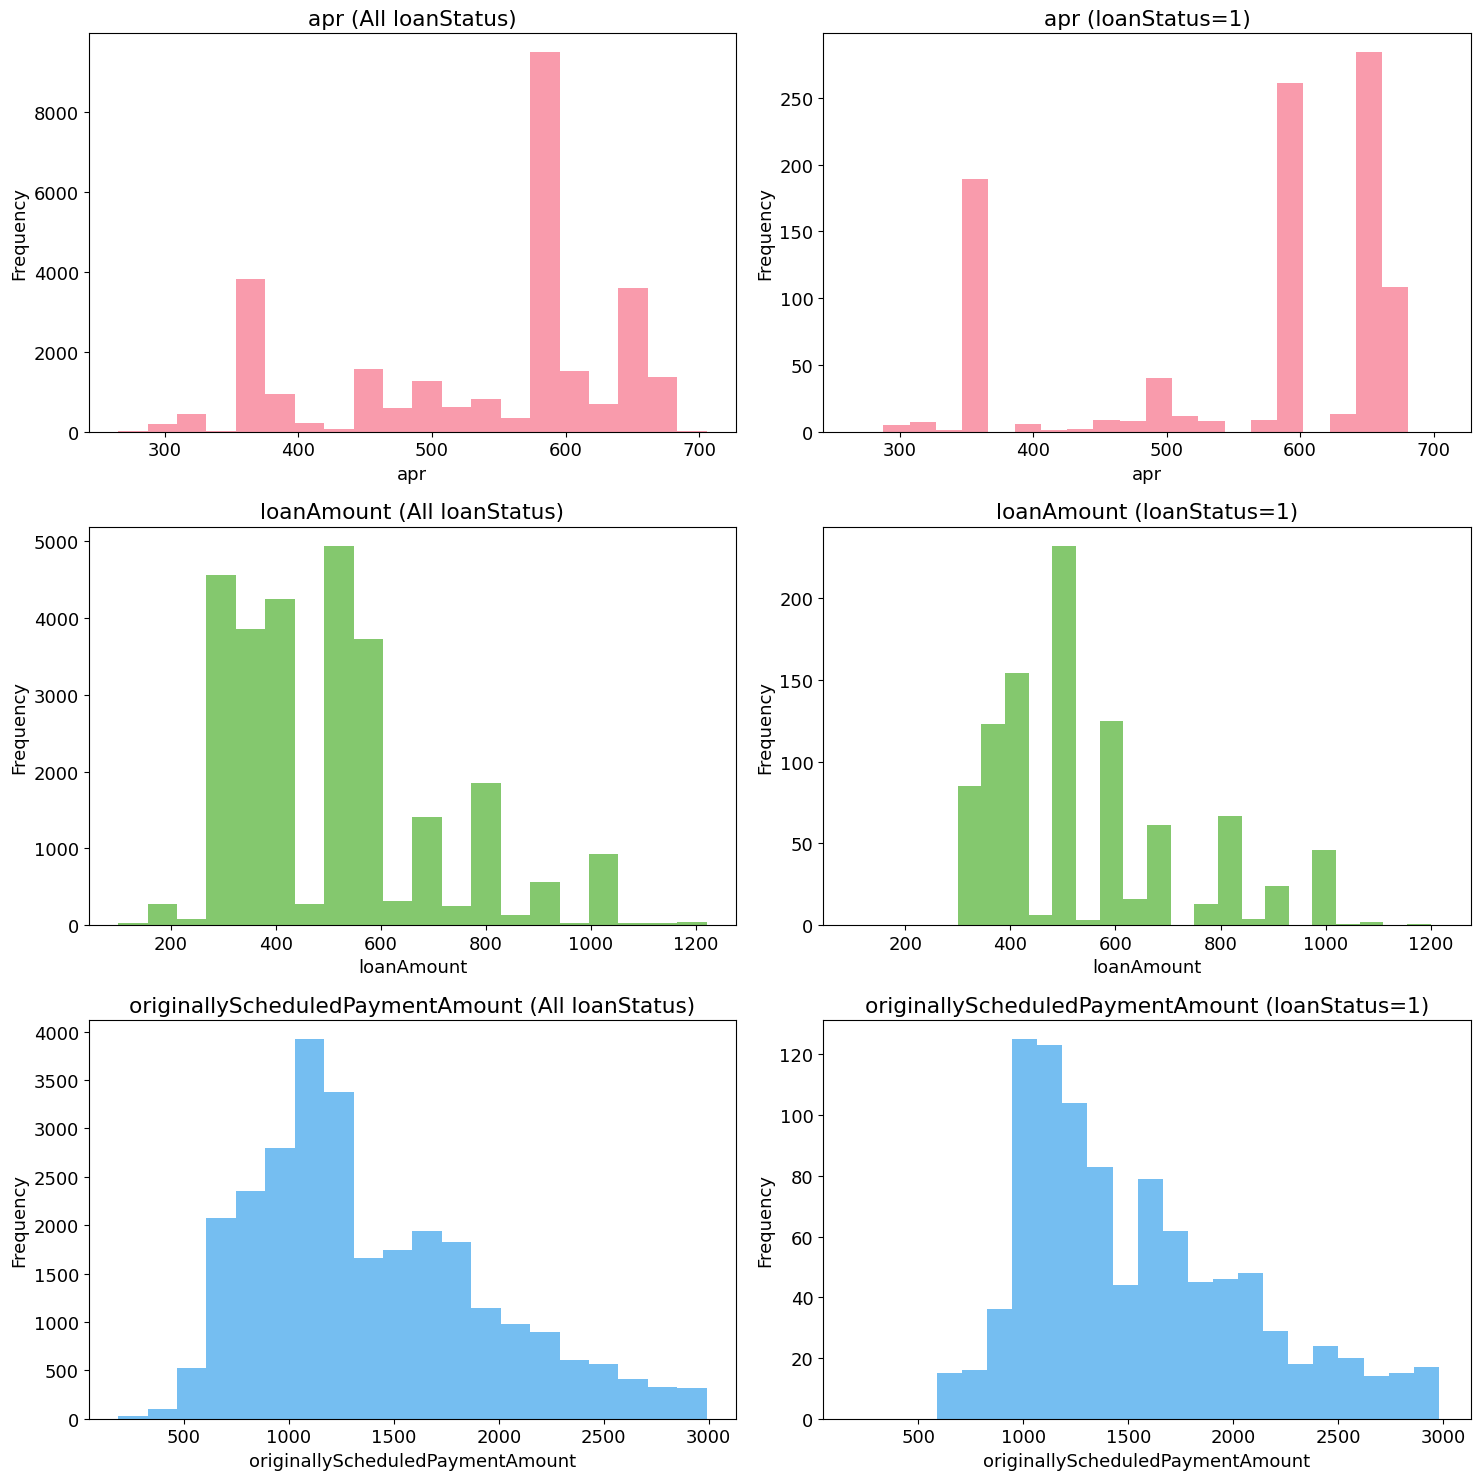

In [604]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(15, 15))

# List of columns to plot
columns = ['apr', 'loanAmount', 'originallyScheduledPaymentAmount']

# Define custom colors for bars
colors = sns.color_palette("husl", len(columns))

# Loop through each column
for i, col in enumerate(columns, start=1):
    # Plot without filtering by loanStatus
    ax1 = plt.subplot(len(columns), 2, i*2-1)
    plt.hist(df[col], bins=20, color=colors[i-1], alpha=0.7)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'{col} (All loanStatus)')
    
    # Plot with filtering by loanStatus == 1
    ax2 = plt.subplot(len(columns), 2, i*2, sharex=ax1)  # Share the same x-axis
    plt.hist(df[df['loanStatus'] == 1][col], bins=20, color=colors[i-1], alpha=0.7)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'{col} (loanStatus=1)')

plt.tight_layout()
plt.show()


Finding:
- The company tend to lend out loan that have higher apr(higher return)
- Most of the loan amount is range between 0-1000, which indicate our client is relatively small and potentially instable 

# Modeling

In this section:
- We address the issue of imbalanced datasets using the Upsampling method, specifically employing Random Sampling in this instance.
- Subsequently, we utilize LGBM to compute the final AUC score.

Please note that given the nature of this data science assessment, we aim to keep the modeling section as concise as possible. However, for further model enhancement, consider the following approaches:
1. Experiment with different upsampling methods such as SMOTE or its extensions. If utilizing SMOTE, ensure to handle missing values accordingly.
2. Conduct hyperparameter tuning using tools like HyperOpt or Optuna to fine-tune our model.
3. Explore various types of K-fold validation techniques to validate the robustness of the final outcome.

In [590]:
X,y = df.drop(['loanId', 'anon_ssn', 'loanStatus','originatedDate','applicationDate'], axis=1), df['loanStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

ros = RandomOverSampler(random_state=88)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

print(f'Class distribution trainset after balancing: \n{y_train_resampled.value_counts(normalize=True).apply(lambda x: f"{x * 100:.2f}%")}\n')
print(f'Class distribution test set: \n{y_test.value_counts(normalize=True).apply(lambda x: f"{x * 100:.2f}%")}\n')

Class distribution trainset after balancing: 
loanStatus
0    50.00%
1    50.00%
Name: proportion, dtype: object

Class distribution test set: 
loanStatus
0    96.52%
1     3.48%
Name: proportion, dtype: object



The key point to remember is that we should **only** apply upsampling method (like SMOTE/RS) to the **training set**. This ensures that the test set retains its real-world data distribution, preventing any potential information leakage.

In [591]:
lgb_train = lgb.Dataset(X_train_resampled, y_train_resampled)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)


In [592]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'roc_auc_score'},
    'num_leaves': 66,
    'num_trees': 15,
    'learning_rate': 0.08,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=50,
#                 valid_sets=lgb_train
               )

y_pred_lgbm = gbm.predict(X_test)
auc_lgbm = roc_auc_score(y_test, y_pred_lgbm)
auc_lgbm

0.8567512678437266

We have achieved an AUC score of approximately 85.67%, indicating that the model effectively discriminates between True Positives (instances correctly predicted as high risk and proven to default) and False Positives (instances incorrectly predicted as high risk but not proven to default).



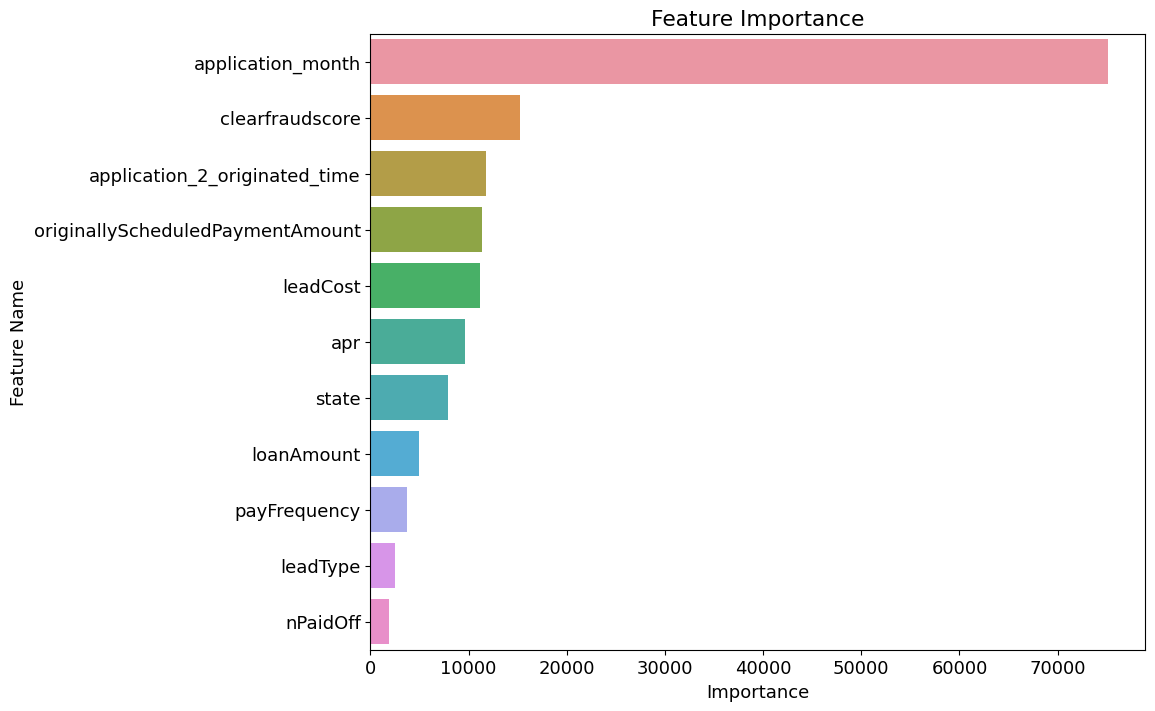

In [593]:
feature_importance = gbm.feature_importance(importance_type='gain')

# Assuming you have a list of feature names in 'feature_names'
# Replace 'feature_names' with the actual list of feature names used in your model
feature_importance_df = pd.DataFrame({'feature_name': X.columns, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature_name', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.show()

# Further Discusssion

Throughout our analysis, we've encountered limitations in feature engineering due to the current dataset's scope. We assumed that the clear fraud score is derived solely from the other columns in the clarity_underwriting_variables dataset. To gain a more comprehensive understanding and improve our predictive capabilities, we may need to access additional information such as:

- Income: This data would allow us to assess whether a loan is financially feasible for an individual.
- Family members: Understanding the borrower's family size can provide insights into their family expenses, such as:
  - Income divided by the number of children
  - Income divided by the total number of family members
  - Proportion of children among family members (number of children divided by family members)
- Employment history: Examining the borrower's work history can help gauge the stability of their income source. For example:
  - Longer tenure at the same company may indicate a stable income and lower risk of default.
- Application history across different financial institutions: Knowing how many loans borrowers have applied for at various institutions can offer valuable context and potential risk indicators.



# Thats all for this notebook Thankyou!~

In [594]:
# payment_df['paymentDate'] = [i[:13] for i in payment_df['paymentDate']]

# # Convert to datetime
# payment_df['paymentDate'] = pd.to_datetime(payment_df['paymentDate'], format='%Y-%m-%dT%H')

# # Group by loanId and sort by paymentDate descending
# payment_df = payment_df.sort_values(by=['loanId', 'paymentDate'], ascending=[True, False])
# payment_df

In [595]:
# df = df.merge(payment_df.groupby('loanId').first(), on='loanId',how ='left')
# # df

In [596]:
# approve_df = df[df['originated']==True]
# approve_df

In [597]:
# approve_df = df[df['isFunded']==1]
# approve_df

In [598]:
# grouped_df = approve_df.groupby('loanStatus')['paymentStatus'].value_counts()
# grouped_df

In [599]:
# unstacked_df = grouped_df.unstack()

# # Plotting the stacked bar chart
# fig, ax = plt.subplots(figsize=(12, 8))
# unstacked_df.plot(kind='bar', stacked=True, ax=ax)

# # Add labels and title
# ax.set_xlabel('Loan Status')
# ax.set_ylabel('Count')
# ax.set_title('Payment Status Count by Loan Status')

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45, ha='right')

# # Show the plot
# plt.tight_layout()
# plt.legend(title='Payment Status')
# plt.show()

Based on the information we gathered from data dictionary, we realised our target variables is most likely <span style="background-color: #f0f0f0; padding: 3px;">Return Item</span>
 as it indicate a missed payment due to insufficient funds. But we are also curious at does the rest indicate a promising loan repayment? With the help of payment df, we gather the latest payment status for each loanId and come out with the graph above.  

In [600]:
# df.groupby('leadType')['approved'].count().sort_values(ascending=False)

In [601]:
# df.groupby('leadType')['approved'].value_counts()

In [602]:
# approve_df[(approve_df['loanStatus'] == 'Withdrawn Application') & (approve_df['paymentStatus'].notnull())]

In [603]:
# underwriting_df